# <center> Newman on custom trace and user graph </center>

In [2]:
import util
import numpy as np
import networkx as nx
import random as random
from operator import itemgetter
from scipy.special import binom
import matplotlib.pyplot as plt

Load trace.

In [84]:
trace_path = "../Datasets/trace_test.txt"

Get authors.

In [85]:
Author = util.get_authors(trace_path)

Get users.

In [86]:
users = set(Author.values())
print(users)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49}


In [87]:
for i,line in enumerate(open(trace_path)):
    print(line[:-1]) # [:-1] to remove \n at end of line
    if i==5:
        break

0 0 34 -1
1 0.033101216539249585 3 -1
2 0.14667717249050982 18 -1
3 0.16370054139895876 18 -1
4 0.2556460941958446 43 -1
5 0.3027567735887114 15 -1


## 1. Initialization

Number of nodes $n$ and list of all node pairs.

In [88]:
n = len(users)
node_pairs = list()
for i in range(n):
    for j in range(n):
        if i != j:
            node_pairs.append((i,j))

Compute E and N. We set the number of observation N[i,j] to the max of E for each (i,j).

/!\ N[i,j] : nb obs for j-->i /!\

/!\ E[i,j] : nb edges observed for j-->i /!\

In [89]:
# init
E = {e:0 for e in node_pairs}
N = {e:0 for e in node_pairs}

# read tweets
for line in open(trace_path):
    line = line.split()
    uid, rtid = int(line[2]), int(line[3])
    
    # if retweet
    if rtid != -1:
        
#         # update N[.,uid]
#         for user in users.difference({uid}):
#             N[uid, user] += 1
            
        # if retweetd user known update E[rtu,uid]
        if rtid in Author:
            rtu = Author[rtid]
            if rtu != uid: # no self-edges
                E[uid,rtu] = min(E[uid,rtu]+1, 30)
                
N = { e:max(E.values()) for e in node_pairs}

In [90]:
print("min E, max E = ", min(E.values()), ",", max(E.values()))

min E, max E =  0 , 30


## 2. Iterations

Choose parameters.

In [91]:
repetitions = 100
max_iter = 100
verbose = False

Proceed.

In [92]:
# at each repetition we save the values of w, a and b
results = {'w':list(), 'a':list(), 'b':list()}

for k in range(repetitions):
    
    # we may have divisions by zero
    try:
    
        # random initialization of the parameters
        w = random.uniform(0,0.2)
        a = random.uniform(0.5,1)
        b = random.uniform(0,0.5)
        if verbose:
            print("init values ", w, a, b)
            print()

        # iter
        for l in range(max_iter):

            old_w, old_a, old_b = w, a, b

            # compute Qij
            Q = dict()
            for (i,j) in node_pairs:
                Q[i,j] = w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j])
                Q[i,j] /= w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j]) + (1-w) * b**E[i,j] * (1-b)**(N[i,j]-E[i,j])
            
            # update w,a,b
            w = sum(Q.values()) / (n*(n-1))
            numerator_a, numerator_b = 0, 0
            denominator_a, denominator_b = 0, 0
            for (i,j) in node_pairs:
                numerator_a += Q[i,j] * E[i,j]
                numerator_b += (1-Q[i,j]) * E[i,j]
                denominator_a += Q[i,j] * N[i,j]
                denominator_b += (1-Q[i,j]) * N[i,j]
            a = numerator_a / denominator_a
            b = numerator_b / denominator_b
            if verbose:
                print(w,a,b)
                print()
            
            # break if no sufficient evolution
            if np.all(np.abs([a-old_a, b-old_b, w-old_w]) < 0.001):
                if verbose:
                    print(np.abs([a-old_a, b-old_b, w-old_w]))
                break
            
        # add results to results dict
        results['w'].append(w)
        results['a'].append(a)
        results['b'].append(b)
        
    except e:
        continue

Print results.

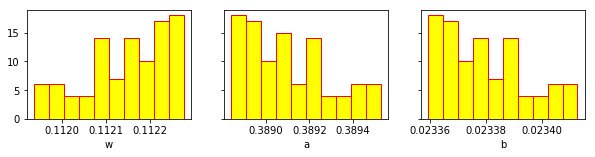

values for w and proportion
0.112 1.0

values for a and proportion
0.389 0.95
0.39 0.05

values for b and proportion
0.023 1.0

values for (w,a,b) and proportion
(0.112, 0.389, 0.023) 0.95
(0.112, 0.39, 0.023) 0.05


In [93]:
# plot the results
plt.rcParams["figure.figsize"] = [10,2]
fig, ax = plt.subplots(1, 3, sharey=True)
for i,(key,values) in enumerate(results.items()):
    values = sorted(values)
    ax[i].hist(values, label=key, facecolor='yellow', edgecolor='red')
    ax[i].set_xlabel(key)
    
plt.show()
plt.close()

# print results
for key,val in results.items():
    print("values for {} and proportion".format(key))
    val = [round(v,3) for v in val]
    for v in set(val):
        print(v, val.count(v)/len(val))
    print()
    
print("values for (w,a,b) and proportion")
val = list()
for i in range(len(results['w'])):
    val.append((round(results['w'][i],3), round(results['a'][i],3), round(results['b'][i],3)))
for v in set(val):
    print(v, val.count(v)/len(val))

Set w,a,b to the most observed values and compute Q accordingly.

w, a, b =  0.112 0.389 0.023


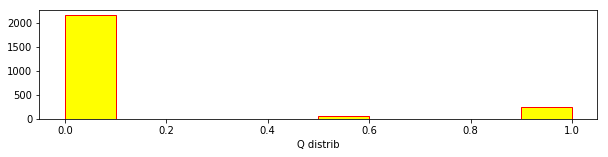

In [94]:
w, a, b = max([(v, val.count(v)/len(val)) for v in set(val)], key=itemgetter(1))[0]
for (i,j) in node_pairs:
    Q[i,j] = w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j])
    Q[i,j] /= w * a**E[i,j] * (1-a)**(N[i,j]-E[i,j]) + (1-w) * b**E[i,j] * (1-b)**(N[i,j]-E[i,j])
print("w, a, b = ", w,a,b)
plt.hist(Q.values(), facecolor='yellow', edgecolor='red')
plt.xlabel("Q distrib")
plt.show()
plt.close()

## 3. Result analysis

### 3.1 Plots

Plot E/N vs Q.

Text(0, 0.5, 'a posteriori edge proba')

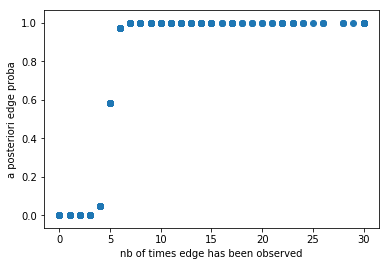

In [95]:
plt.rcParams["figure.figsize"] = [6,4]
x2plot = [E[e] for e in node_pairs]
y2plot = [Q[e] for e in node_pairs]
plt.scatter(x2plot, y2plot)
plt.xlabel("nb of times edge has been observed")
plt.ylabel("a posteriori edge proba")

Get real graph.

In [96]:
G = nx.DiGraph()
G.add_nodes_from(users)

for line in open("../Datasets/leadgraph_test.txt"):
    line = line.split()
    user = int(line[0])
    for leader in line[1:]:
        leader = int(leader)
        G.add_edge(leader, user)

Estimate $\omega$ from real graph and get real values of $a,b$.

In [97]:
print("w,a,b form Newman algo : ", w,a,b,'\n')

w_estimated_from_real_graph = G.number_of_edges() / (2*binom(n,2))
print("estimated w from real graph = ", w_estimated_from_real_graph)

a_numerator, a_denominator = 0, 0
for e in G.edges:
    a_numerator += E[e]
    a_denominator += N[e]
print("real a = ", a_numerator/a_denominator)

b_numerator, b_denominator = 0, 0
for e in node_pairs:
    if e not in G.edges:
        b_numerator += E[e]
        b_denominator += N[e]
print("real b = ", b_numerator/b_denominator)

w,a,b form Newman algo :  0.112 0.389 0.023 

estimated w from real graph =  0.10163265306122449
real a =  0.05515394912985275
real b =  0.06543995153718007


Compare expected degrees.

In [100]:
expected_deg = 2*sum(Q.values())/n
var = 4*sum([q*(1-q) for q in Q.values()]) / n**2
std = np.sqrt(var)
print("Expected degree observed : {:.3f} with variance {:.3f} and std_dev {:.3f}".format(expected_deg, var, std))
print("Expected degree estimated from real graph : {:.3f}".format(np.mean(G.degree())))

Expected degree observed : 11.069 with variance 0.028 and std_dev 0.169
Expected degree estimated from real graph : 17.230


### 3.2 Sample generation

We generate several sample graphs according to the posterior distribution. We compare their edges with edges from the real graph.

In [99]:
n_samples = 1000
prop_sampleEdges_in_real = list()
prop_realEdges_in_sample = list()

for k in range(n_samples):
    
    # sample graph
    G_sample = nx.DiGraph()
    G_sample.add_nodes_from(users)
    for e in node_pairs:
        if random.random() < Q[e]:
            G_sample.add_edge(e[1], e[0])
            
    # compare edges in sample with real graph
    prop_sampleEdges_in_real = len([e for e in G_sample.edges if e in G.edges]) / G_sample.number_of_edges()
    prop_realEdges_in_sample = len([e for e in G.edges if e in G_sample.edges]) / G.number_of_edges()
    
# print results
print("Mean prop of sample edges present in real graph : ", np.mean(prop_sampleEdges_in_real))
print("Mean prop of real edges present in sample graph : ", np.mean(prop_realEdges_in_sample))

Mean prop of sample edges present in real graph :  0.5448028673835126
Mean prop of real edges present in sample graph :  0.6104417670682731


## 4. Unused

Reduce the scale of N and E to avoid floats problems.

In [27]:
# def scaling(x, I1, I2):
#     # scales x from interval I1=[A,B] to I2=[a,b]
#     A, B = I1[0], I1[1]
#     a, b = I2[0], I2[1]
#     return ((b-a)*x + a*B - A*b) / (B-A)

# I1 = (min(E.values()), max(N.values()))
# I2 = (2,4)
# for e in N:
#     N[e] = scaling(N[e], I1, I2)
#     E[e] = scaling(E[e], I1, I2)
    
# # old scaling
# scaling_factor = 20 / max(E.values())
# for e in N:
#     N[e] *= scaling_factor
#     E[e] *= scaling_factor